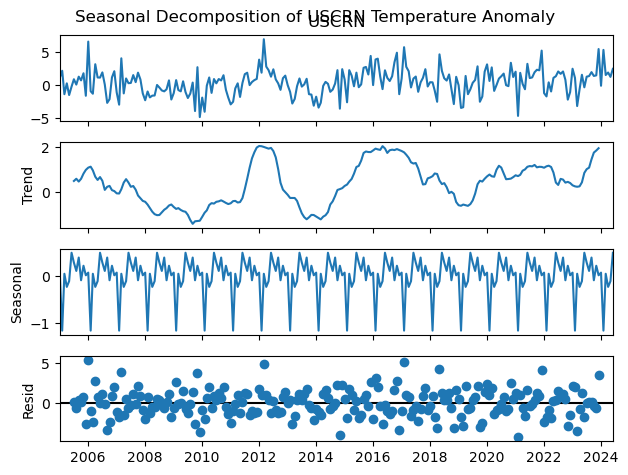

<Figure size 1400x400 with 0 Axes>

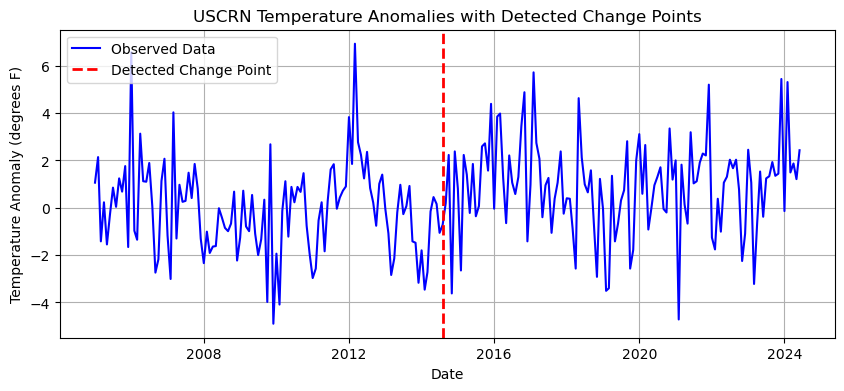

Mean from 2005-01-01 00:00:00 to 2014-07-01 00:00:00: -0.10
Mean from 2014-08-01 00:00:00 to 2024-06-01 00:00:00: 0.90


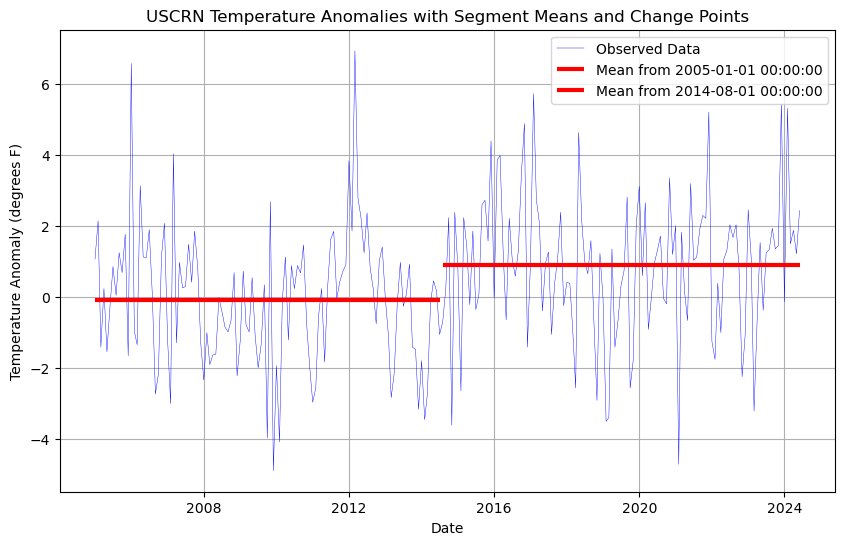

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
import ruptures as rpt

# Step 1: Load the Data from the URL
url = "https://www.ncei.noaa.gov/access/monitoring/national-temperature-index/time-series/anom-tavg/1/0/data.csv"
data = pd.read_csv(url, skiprows=1)  # Skip the first descriptive row

# Rename columns according to the provided structure
data.columns = ['Date', 'ClimDiv', 'USCRN']
c = 'USCRN'  # Column to analyze

# Convert 'Date' to a datetime format assuming 'YYYYMM' format
data['Date'] = pd.to_datetime(data['Date'], format='%Y%m')

# Convert 'ClimDiv' to numeric and filter out invalid values (-99.99 or -9999)
data[c] = pd.to_numeric(data[c], errors='coerce')
filtered_data = data[data[c] != -99.99]

# Start analysis from the first valid date
first_valid_date = filtered_data['Date'].min()
filtered_data = filtered_data[filtered_data['Date'] >= first_valid_date]


# Step 3: Time Series Analysis
ts = filtered_data.set_index('Date')[c]


# Step 5: Seasonal Decomposition
decomposition = seasonal_decompose(ts.dropna(), model='additive', period=12)
decomposition.plot()
plt.suptitle(f'Seasonal Decomposition of {c} Temperature Anomaly')
plt.figure(figsize=(14, 4))
plt.show()

# Step 6: Change Point Detection
# Use the Pelt method to detect change points
algo = rpt.Pelt(model="rbf").fit(ts.dropna().values)
penalty = 3
result = algo.predict(pen=penalty)

# Plot the data with detected change points
plt.figure(figsize=(10, 4))
plt.plot(ts, label='Observed Data', color='blue')
for cp in result[:-1]:  # Exclude the last point which is the end of the data
    if cp < len(ts):  # Ensure the change point index is valid
        plt.axvline(x=ts.index[cp], color='red', linestyle='--', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Temperature Anomaly (degrees F)')
plt.title(f'{c} Temperature Anomalies with Detected Change Points')
plt.legend(['Observed Data', 'Detected Change Point'])
plt.grid(True)
plt.show()

# Step 7: Segment Analysis
# Calculate means for segments defined by the change points
if len(result) > 1:
    # Ensure indices are within valid range
    valid_results = [cp for cp in result if cp < len(ts)]
    
    # Add the start and end points for segment analysis
    segment_points = [0] + valid_results + [len(ts)]
    
    # Plot the observed data
    plt.figure(figsize=(10, 6))
    plt.plot(ts.index, ts.values, label='Observed Data', color='blue', linewidth=0.3)
    
    # Calculate and plot the mean for each segment
    for i in range(len(segment_points) - 1):
        start_idx = segment_points[i]
        end_idx = segment_points[i + 1]
        segment_mean = ts.iloc[start_idx:end_idx].mean()
        plt.hlines(segment_mean, ts.index[start_idx], ts.index[end_idx - 1], colors='red', linestyles='solid', linewidth=3, label=f'Mean from {ts.index[start_idx]}')
        print(f"Mean from {ts.index[start_idx]} to {ts.index[end_idx - 1]}: {segment_mean:.2f}")

    plt.xlabel('Date')
    plt.ylabel('Temperature Anomaly (degrees F)')
    plt.title(f'{c} Temperature Anomalies with Segment Means and Change Points')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No significant change points detected.")
